# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           calculate_parameter_sensitivity,
                           plot_parameter_sensitivity,
                           plot_regression_fit)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [5]:
from channels.icat_generic import icat as model
test = model.sample({})

# Get experimental measurements

In [6]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [24]:
limits = dict(g_CaT=(0, 2),
              v_offset=(0, 500),
              Vhalf_b=(-100, 100),
              k_b=(0, 10),
              c_bb=(0, 10),
              c_ab=(0, 100),
              sigma_b=(0, 100),
              Vmax_b=(-100, 100),
              Vhalf_g=(-100, 100),
              k_g=(-10, 0),
              c_bg=(0, 50),
              c_ag=(0, 500),
              sigma_g=(0, 100),
              Vmax_g=(-100, 100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Parameter sensitivity analysis

In [8]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

In [9]:
parameters = ['icat.'+k for k in limits.keys()]

In [10]:
fitted, regression_fit, r2 = calculate_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.05,
    n_samples=1000)

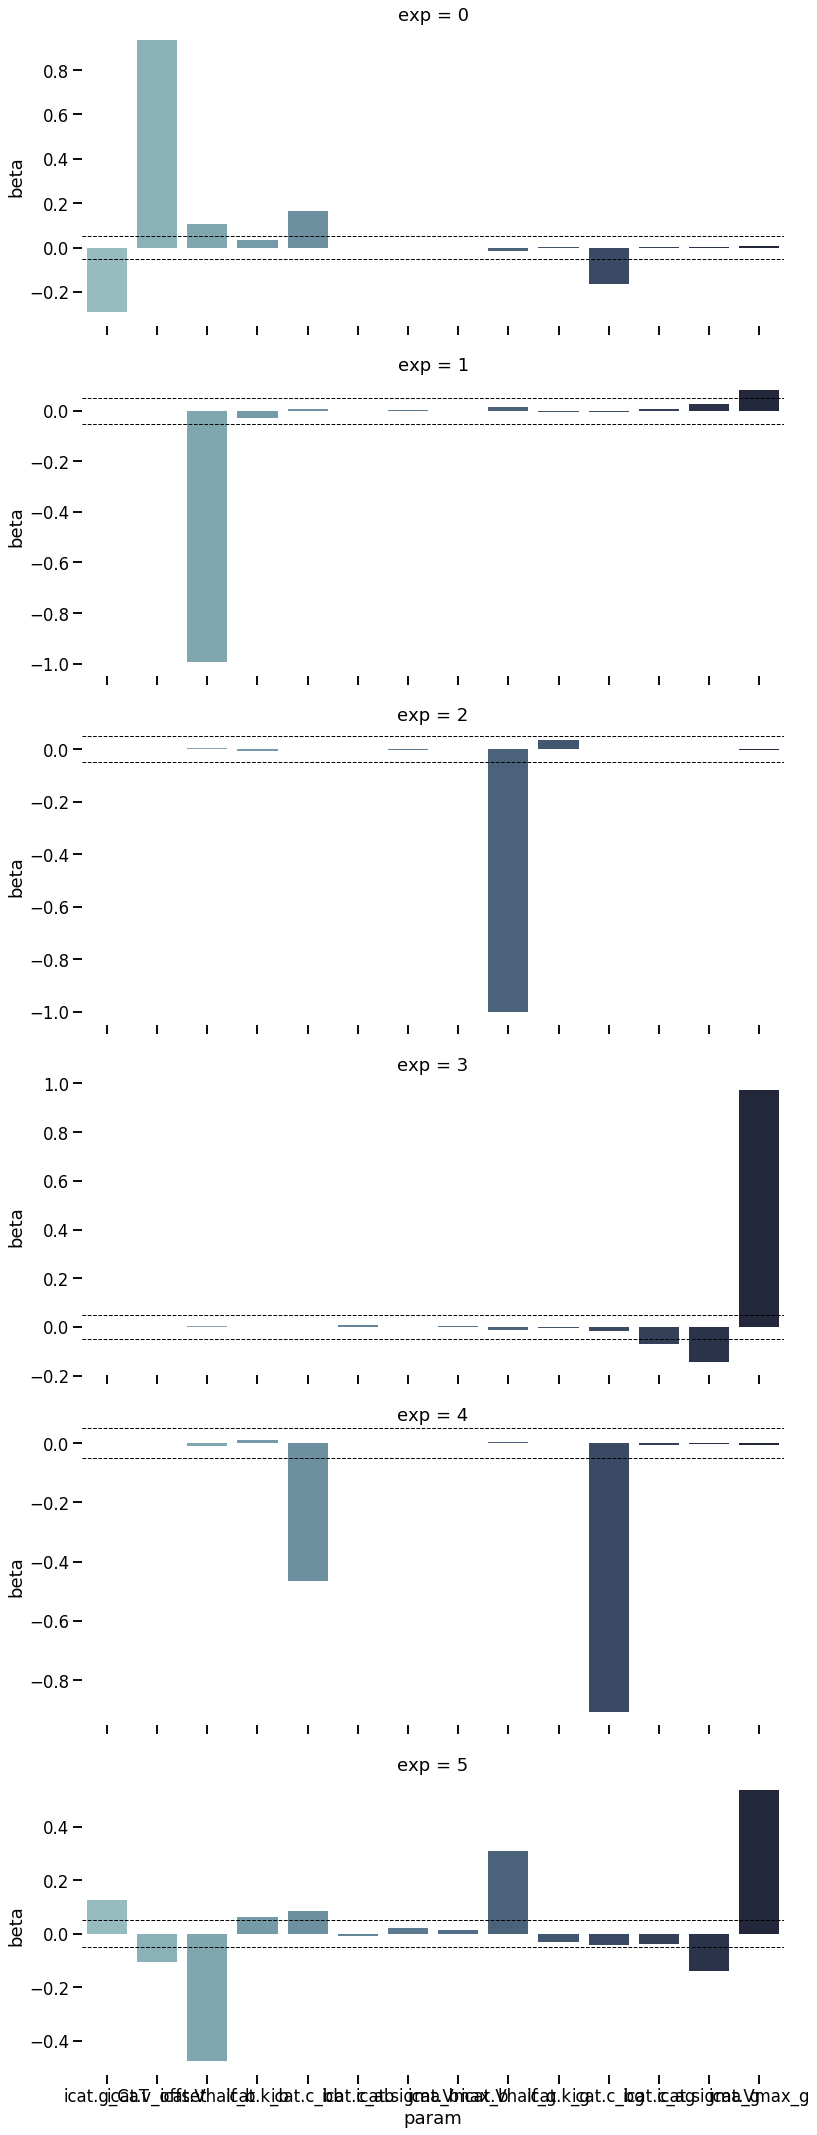

In [11]:
sns.set_context('talk')
grid = plot_parameter_sensitivity(fitted, plot_cutoff=0.05)

In [12]:
grid.savefig('results/icat-generic/sensitivity.pdf')

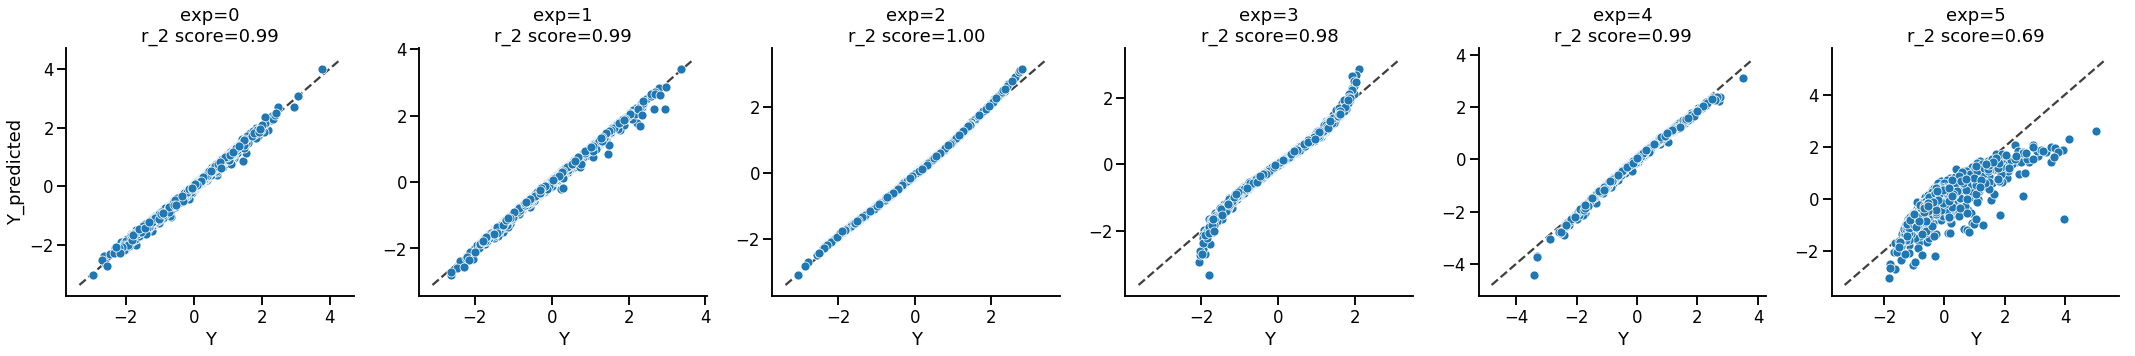

In [13]:
grid2 = plot_regression_fit(regression_fit, r2)

In [14]:
grid2.savefig('results/icat-generic/sensitivity_fit.pdf')

# Weights of distance function

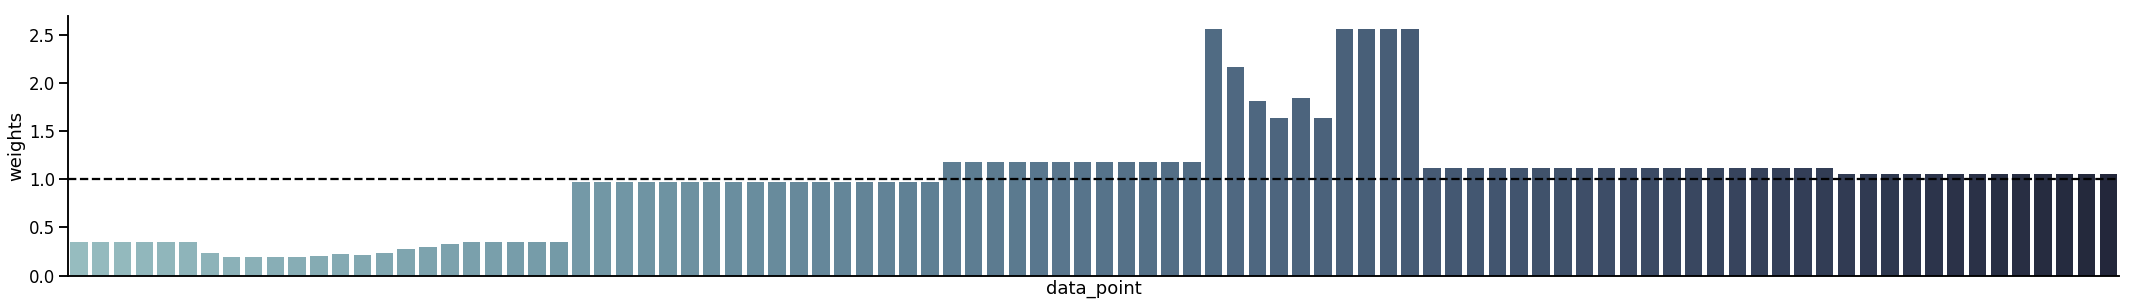

In [17]:
from ionchannelABC import plot_distance_weights
grid = plot_distance_weights(model, distance_fn)

In [18]:
grid.savefig('results/icat/dist_weights.pdf')

# Initialize pyabc database

In [31]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl-1_icat-generic.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_icat-generic.db


In [32]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [33]:
from pyabc.populationstrategy import ConstantPopulationSize

In [34]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=ConstantPopulationSize(1000),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=1000,
             #    mean_cv=0.2,
             #    max_population_size=1000,
             #    min_population_size=100),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.3437158292831627, 1: 0.3437158292831627, 2: 0.3437158292831627, 3: 0.3437158292831627, 4: 0.3437158292831627, 5: 0.3437158292831627, 6: 0.23359946175355675, 7: 0.19709954585456368, 8: 0.19709954585456368, 9: 0.19709954585456368, 10: 0.19406724514910909, 11: 0.20345759572083993, 12: 0.22525662383378656, 13: 0.21023951557820128, 14: 0.23800699876777479, 15: 0.27422545510200186, 16: 0.30034216511171646, 17: 0.32344540858184795, 18: 0.3437158292831627, 19: 0.3437158292831627, 20: 0.3437158292831627, 21: 0.3437158292831627, 22: 0.3437158292831627, 23: 0.9694434159168854, 24: 0.9694434159168854, 25: 0.9694434159168854, 26: 0.9694434159168854, 27: 0.9694434159168854, 28: 0.9694434159168854, 29: 0.9694434159168854, 30: 0.9694434159168854, 31: 0.9694434159168854, 32: 0.9694434159168854, 33: 0.9694434159168854, 34: 0.9694434159168854, 35: 0.9694434159168854, 36: 0.9694434159168854, 37: 0.9694434159168854, 38: 0.9694434159168854, 39: 0.9694434159168854, 40: 1.

In [35]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2018-11-25 14:37:55.757218, end_time=None)>
INFO:Epsilon:initial epsilon is 63.590755296150036


In [36]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=30, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:63.590755296150036
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 1879
DEBUG:Epsilon:new eps, t=1, eps=10.311120027697005
INFO:ABC:t:1 eps:10.311120027697005
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 4286
DEBUG:Epsilon:new eps, t=2, eps=9.360047366572276
INFO:ABC:t:2 eps:9.360047366572276
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 6878
DEBUG:Epsilon:new eps, t=3, eps=8.874159054474884
INFO:ABC:t:3 eps:8.874159054474884
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 11328
DEBUG:Epsilon:new eps, t=4, eps=8.472655966987986
INFO:ABC:t:4 eps:8.472655966987986
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 16330
DEBUG:Epsilon:new eps, t=5, eps=8.3

In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=30, min_acceptance_rate=0.01)

INFO:ABC:t:39 eps:1.1367961806528684
DEBUG:ABC:now submitting population 39
DEBUG:ABC:population 39 done
DEBUG:ABC:
total nr simulations up to t =39 is 1327369
DEBUG:Epsilon:new eps, t=40, eps=1.1084314011281138
INFO:ABC:t:40 eps:1.1084314011281138
DEBUG:ABC:now submitting population 40
DEBUG:ABC:population 40 done
DEBUG:ABC:
total nr simulations up to t =40 is 1374876
DEBUG:Epsilon:new eps, t=41, eps=1.0849294514138603
INFO:ABC:t:41 eps:1.0849294514138603
DEBUG:ABC:now submitting population 41


In [91]:
limits = dict(g_CaT=(0, 2),
              v_offset=(0, 500),
              Vhalf_b=(-100, 100),
              k_b=(0, 10),
              c_bb=(0, 10),
              c_ab=(0, 100),
              sigma_b=(0, 100),
              Vmax_b=(-100, 100),
              Vhalf_g=(-100, 100),
              k_g=(-10, 0),
              c_bg=(0, 50),
              c_ag=(0, 1000), # increased 500 -> 1000
              sigma_g=(0, 100),
              Vmax_g=(-100, 100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [92]:
abc_continued = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=ConstantPopulationSize(1000),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=1000,
             #    mean_cv=0.2,
             #    max_population_size=1000,
             #    min_population_size=100),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.3437158292831627, 1: 0.3437158292831627, 2: 0.3437158292831627, 3: 0.3437158292831627, 4: 0.3437158292831627, 5: 0.3437158292831627, 6: 0.23359946175355675, 7: 0.19709954585456368, 8: 0.19709954585456368, 9: 0.19709954585456368, 10: 0.19406724514910909, 11: 0.20345759572083993, 12: 0.22525662383378656, 13: 0.21023951557820128, 14: 0.23800699876777479, 15: 0.27422545510200186, 16: 0.30034216511171646, 17: 0.32344540858184795, 18: 0.3437158292831627, 19: 0.3437158292831627, 20: 0.3437158292831627, 21: 0.3437158292831627, 22: 0.3437158292831627, 23: 0.9694434159168854, 24: 0.9694434159168854, 25: 0.9694434159168854, 26: 0.9694434159168854, 27: 0.9694434159168854, 28: 0.9694434159168854, 29: 0.9694434159168854, 30: 0.9694434159168854, 31: 0.9694434159168854, 32: 0.9694434159168854, 33: 0.9694434159168854, 34: 0.9694434159168854, 35: 0.9694434159168854, 36: 0.9694434159168854, 37: 0.9694434159168854, 38: 0.9694434159168854, 39: 0.9694434159168854, 40: 1.

In [94]:
abc_continued.load(db_path, 1)

INFO:Epsilon:initial epsilon is 0.0


1

In [95]:
abc_continued.run(minimum_epsilon=0.1, max_nr_populations=30, min_acceptance_rate=0.01)

INFO:ABC:t:69 eps:0.0
DEBUG:ABC:now submitting population 69
DEBUG:ABC:population 69 done
DEBUG:ABC:
total nr simulations up to t =69 is 1861743
DEBUG:Epsilon:new eps, t=70, eps=0.0
INFO:History:Done <ABCSMC(id=1, start_time=2018-11-25 14:37:55.757218, end_time=2018-11-26 13:03:27.849820)>


# Results analysis

In [19]:
history = History('sqlite:////storage/hhecm/cellrotor/chouston/results/icat-generic/hl-1_icat-generic.db')
#history = History('sqlite:////storage/hhecm/cellrotor/chouston/results/convergence/icat-generic/hl-1_icat3000.db')
#history = History('sqlite:////scratch/cph211/ion-channel-ABC/docs/examples/results/icat-generic/hl-1_icat-generic.db')
history.all_runs()

[<ABCSMC(id=1, start_time=2018-11-25 14:37:55.757218, end_time=2018-11-26 02:37:56.090629)>]

In [20]:
#history.id = 5 # with v offset
history.id = 1

In [21]:
sns.set_context('talk')

In [22]:
df, w = history.get_distribution(m=0)

In [23]:
df.describe()

name,Vhalf_b,Vhalf_g,Vmax_b,Vmax_g,c_ab,c_ag,c_bb,c_bg,g_CaT,k_b,k_g,sigma_b,sigma_g,v_offset
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-30.264518,-51.486877,69.025636,-61.246018,67.615307,486.608905,7.441140,12.752442,0.690610,4.870948,-2.056020,31.439431,15.906836,93.511492
std,0.704147,0.344502,10.698175,0.470904,21.476823,8.885988,0.577561,0.644504,0.050948,0.200684,0.131020,5.021660,0.325512,1.003951
min,-31.902319,-52.305259,28.638882,-62.514154,9.043125,440.571562,5.842019,10.842905,0.568780,4.377142,-2.431913,14.475125,14.817663,88.061775
25%,-30.793645,-51.733786,62.473223,-61.583814,53.170506,481.428601,7.076317,12.340254,0.656435,4.715226,-2.150110,28.059836,15.685692,92.834300
50%,-30.325153,-51.511293,69.123310,-61.291409,71.758719,487.924410,7.444496,12.725284,0.689770,4.857366,-2.064051,31.277985,15.890710,93.570069
75%,-29.805146,-51.256917,76.202683,-60.904582,84.390008,493.349357,7.792669,13.201129,0.722039,5.011693,-1.974032,34.701593,16.112563,94.194007
max,-28.019770,-50.311672,97.608810,-59.798180,99.936991,499.985615,9.445824,14.706022,0.846742,5.454903,-1.575853,45.874915,16.946172,95.807574


In [13]:
#df2 = df
#df2['weight'] = w
#df_melt = df2.melt(value_vars=df2.columns[:-1],id_vars='weight')

In [14]:
#sns.relplot(x='value',y='weight',row='name',data=df_melt,facet_kws={'sharex': False, 'sharey': False})

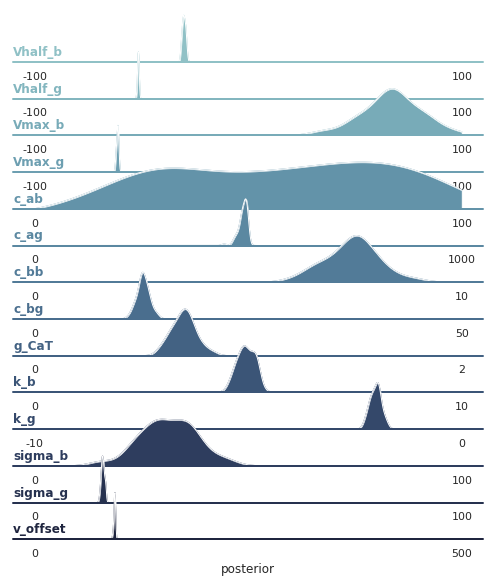

In [25]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits,aspect=12,height=0.6)

In [65]:
g.savefig('results/icat-generic/parameters_kde.pdf')

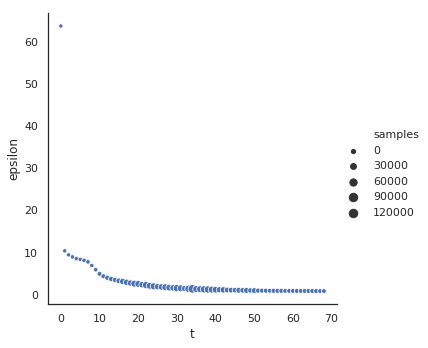

In [26]:
evolution = history.get_all_populations()
g = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
#g.savefig('results/icat-generic/eps_evolution.pdf')

# Samples for quantitative analysis

In [27]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [28]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

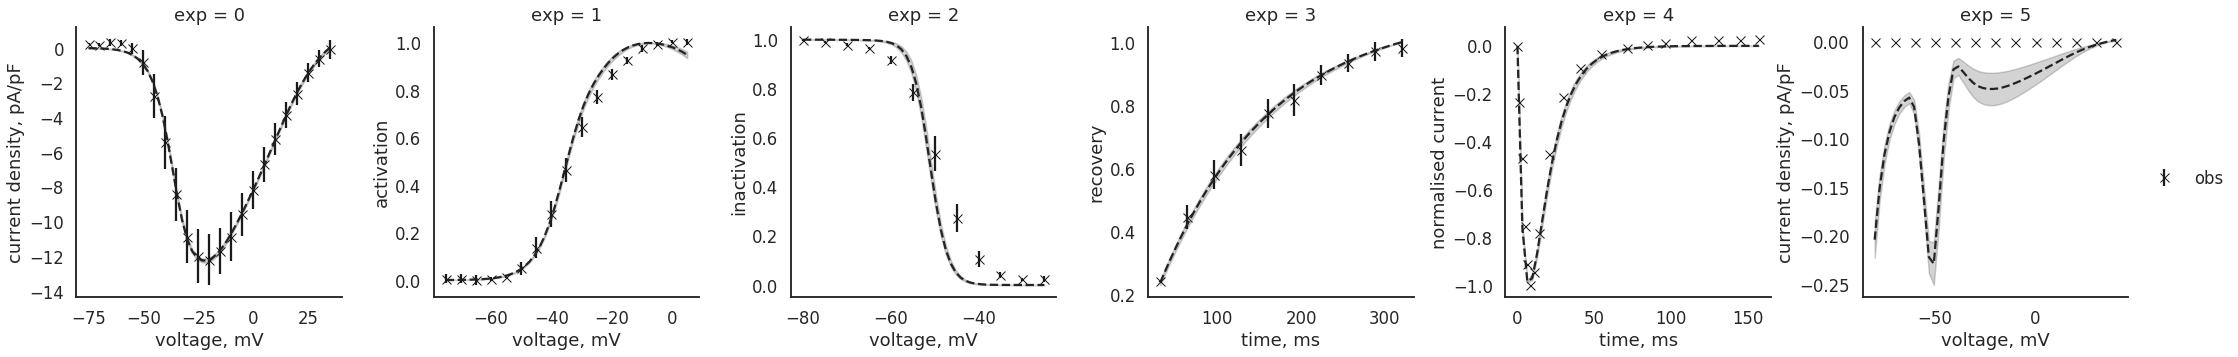

In [29]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms", "time, ms","voltage, mV"]
ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery", "normalised current","current density, pA/pF"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [70]:
g.savefig('results/icat-generic/icat_sim_results.pdf')

In [71]:
def plot_sim_results_all(samples: pd.DataFrame):
    with sns.color_palette("gray"):
        grid = sns.relplot(x='x', y='y',
                           col='exp',
                           units='sample',
                           kind='line',
                           data=samples,
                           estimator=None, lw=0.5,
                           alpha=0.5,
                           #estimator=np.median,
                           facet_kws={'sharex': 'col',
                                      'sharey': 'col'})
    return grid

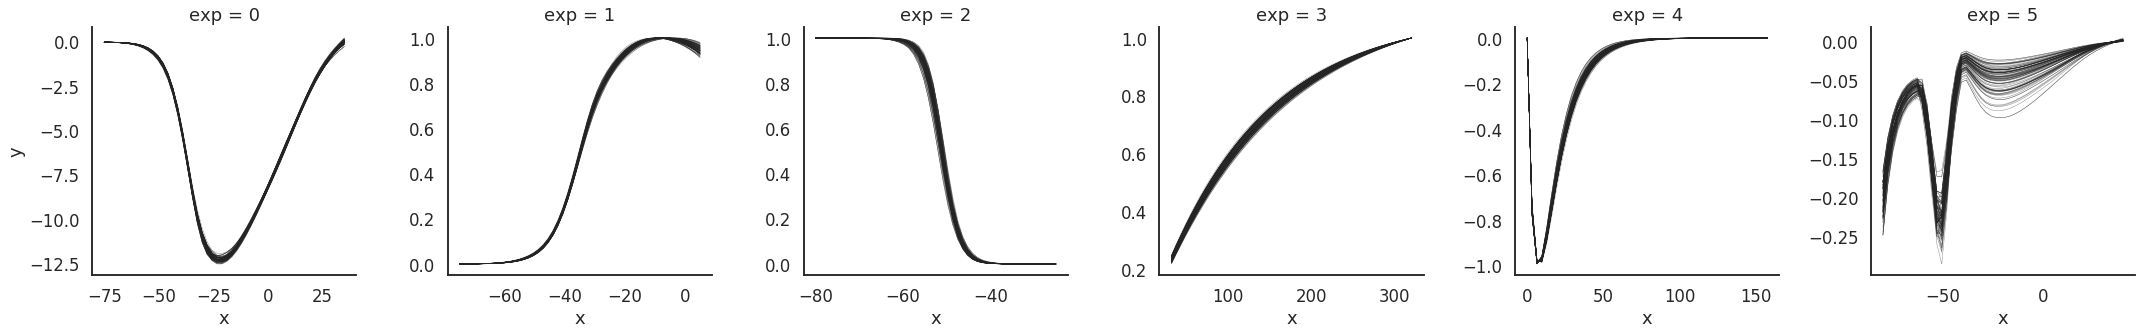

In [72]:
grid2 = plot_sim_results_all(samples)

In [73]:
grid2.savefig('results/icat-generic/icat_sim_results_all.pdf')

In [74]:
# Mean current density
print(np.mean(samples[samples.exp==0].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp==0].groupby('sample').min()['y']))

-12.28849522978163
0.11884277718478846


In [75]:
import scipy.stats as st
peak_current = samples[samples['exp']==0].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [76]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -12.305081453952692
95% CI: (-12.500217629136861, -12.042063814242947)


In [77]:
# Voltage of peak current density
idxs = samples[samples.exp==0].groupby('sample').idxmin()['y']
print("mean: {}".format(np.mean(samples.iloc[idxs]['x'])))
print("STD: {}".format(np.std(samples.iloc[idxs]['x'])))

mean: -21.885714285714286
STD: 1.0634278539232422


In [78]:
voltage_peak = samples.iloc[idxs]['x'].tolist()
rv = st.rv_discrete(values=(voltage_peak, [1/len(voltage_peak),]*len(voltage_peak)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -21.122448979591837
95% CI: (-23.367346938775512, -21.122448979591837)


In [79]:
# Half activation potential
# Fit of activation to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [80]:
print(np.mean(output))
print(np.std(output))

0   -34.577896
1     5.249907
dtype: float64
0    0.235155
1    0.153233
dtype: float64


In [81]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -34.58363058983856
95% CI: (-35.0824309590915, -34.05139450727638)


In [82]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.224802366288811
95% CI: (4.983346458403857, 5.580422234103727)


In [83]:
# Half activation potential
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-100, 1], [0, 30]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [84]:
print(np.mean(output))
print(np.std(output))

0   -51.099701
1     2.015624
dtype: float64
0    0.324099
1    0.124022
dtype: float64


In [85]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -51.139541001530084
95% CI: (-51.91973135023897, -50.483201273719196)


In [86]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 1.9931521591606465
95% CI: (1.7945341598364295, 2.2778268479073294)


In [87]:
# Recovery time constant
grouped = samples[samples.exp==3].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp)

In [88]:
print(np.mean(output))
print(np.std(output))

134.15783981052365
6.8765524851314765


In [89]:
tau = output.tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 134.09052469517178
95% CI: (124.17078543531227, 147.7723663936914)
